# introduction

Objectif: Prédire par reseau de neurone la position sur une image

On a une serie d'image IRM avec un fichier rle qui contient 2 colonnes : ImageId (pour relier le fichier avec les images) et EncodedPixels qui contient -1 si absence de maladie ou une serie de coordonnées pour segmenter la présence d'une maladie.

On va créer 2 modèles :     
- 1er modèle : prédire si il y a un problème
- 2ème modèle : prédire ou est le problème

# import library

In [ ]:
# system
import os
import pandas as pd
import numpy as np
from google.colab import drive

# visualsation
import matplotlib.pyplot as plt
from PIL import Image

# pytorch
!pip install segmentation-models-pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Transformers
from torchvision import models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# DICOM
!pip install pydicom
import pydicom

# Split train/test
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.2 MB/s eta 0:00:00


# import files

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder = '/content/drive/MyDrive/Projet_ML/Defi_3_segmentation_image/dicom_images_train'
valid_folder = '/content/drive/MyDrive/Projet_ML/Defi_3_segmentation_image/dicom_images_valid'

In [ ]:
dcm_train = [os.path.join(train_folder, f)
             for f in os.listdir(train_folder) if f.lower().endswith('.dcm')]

dcm_valid = [os.path.join(valid_folder, f)
             for f in os.listdir(valid_folder) if f.lower().endswith('.dcm')]

print(f"Nombre d'images dcm_train trouvées : {len(dcm_train)}")
print(f"Nombre d'images dcm_valid trouvées : {len(dcm_valid)}")

Nombre d'images dcm_train trouvées : 9494
Nombre d'images dcm_valid trouvées : 1000


Patient ID: facfb2b7-db8c-45fa-8ce2-bf45318a8a29
Modality: CR
Image size: 1024 x 1024


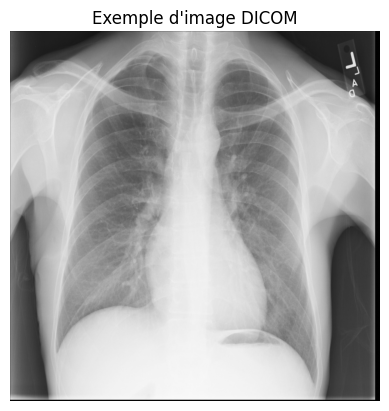

In [ ]:
# Charger la première image
ds = pydicom.dcmread(dcm_train[0])

# Afficher quelques métadonnées
print("Patient ID:", ds.PatientID)
print("Modality:", ds.Modality)
print("Image size:", ds.Rows, "x", ds.Columns)

# Afficher l'image
plt.imshow(ds.pixel_array, cmap='gray')
plt.title("Exemple d'image DICOM")
plt.axis('off')
plt.show()

In [ ]:
!gdown 1ZPHmY4nF0Oxmgl3Nu37emx15l3tJCtSD -O trainSet_rle.csv

Downloading...
From: https://drive.google.com/uc?id=1ZPHmY4nF0Oxmgl3Nu37emx15l3tJCtSD
To: /content/trainSet_rle.csv
100% 4.72M/4.72M [00:00<00:00, 30.4MB/s]


In [ ]:
rle = pd.read_csv("trainSet_rle.csv", sep =";")
rle.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


# Datamanagement

- il y a 9494 images dans le dossier
- rle contient 10504 lignes dont 9676 ID unique
- on enlève les ID qui n'ont pas d'image et on obtient 10270 lignes dont 9458 unique

In [ ]:
df = rle.copy()
valid_ids = {os.path.splitext(f)[0] for f in os.listdir(train_folder) if f.endswith('.dcm')}
df = df[df["ImageId"].isin(valid_ids)]
df["disease"] = np.where(df["EncodedPixels"] == "-1", 0, 1)
display(df.head())
len(df)

,ImageId,EncodedPixels,disease
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,1
5,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,162376 12 1007 18 1003 22 999 26 996 28 993 3...,1


10270

# disease_dedection

## Dataset

In [ ]:
class DicomDataset(Dataset):
    def __init__(self, df, train_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.train_folder = train_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.train_folder, f"{row['ImageId']}.dcm")
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)
        img = Image.fromarray((img * 255).astype(np.uint8)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row['disease'], dtype=torch.float32)
        return img, label

## Transformers

In [ ]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # [0,1]
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

## Split train/val

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['disease'], random_state=42)
train_ds = DicomDataset(train_df, train_folder, transform=train_tfms)
val_ds   = DicomDataset(val_df, train_folder, transform=val_tfms)

## Dataloader

In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

## model_classification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # 1 neurone (binaire)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()             # pour la classification binaire
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        # Affiche toutes les 10 itérations
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}")

        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Epoch 1/5
  Batch 0/65
  Batch 10/65
  Batch 20/65
  Batch 30/65
  Batch 40/65
  Batch 50/65
  Batch 60/65
Epoch 2/5
  Batch 0/65
  Batch 10/65
  Batch 20/65
  Batch 30/65
  Batch 40/65
  Batch 50/65
  Batch 60/65
Epoch 3/5
  Batch 0/65
  Batch 10/65
  Batch 20/65
  Batch 30/65
  Batch 40/65
  Batch 50/65
  Batch 60/65
Epoch 4/5
  Batch 0/65
  Batch 10/65
  Batch 20/65
  Batch 30/65
  Batch 40/65
  Batch 50/65
  Batch 60/65
Epoch 5/5
  Batch 0/65
  Batch 10/65
  Batch 20/65
  Batch 30/65
  Batch 40/65
  Batch 50/65
  Batch 60/65


## evaluation

In [ ]:
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1)
        probs = torch.sigmoid(model(x))
        all_preds.extend((probs.cpu().numpy() > 0.5).astype(int))
        all_labels.extend(y.cpu().numpy())

# Conversion en arrays
all_labels = np.array(all_labels).flatten()
all_preds  = np.array(all_preds).flatten()

In [ ]:
print(f"Accuracy  : {accuracy_score(all_labels, all_preds):.3f}")
print(f"Precision : {precision_score(all_labels, all_preds):.3f}")
print(f"Recall    : {recall_score(all_labels, all_preds):.3f}")
print(f"F1-score  : {f1_score(all_labels, all_preds):.3f}")
print("Matrice de confusion :\n", confusion_matrix(all_labels, all_preds))
print("Classification report :\n", classification_report(all_labels, all_preds))

Accuracy  : 0.828
Precision : 0.662
Recall    : 0.805
F1-score  : 0.727
Matrice de confusion :
 [[1229  240]
 [ 114  471]]
Classification report :
               precision    recall  f1-score   support

         0.0       0.92      0.84      0.87      1469
         1.0       0.66      0.81      0.73       585

    accuracy                           0.83      2054
   macro avg       0.79      0.82      0.80      2054
weighted avg       0.84      0.83      0.83      2054



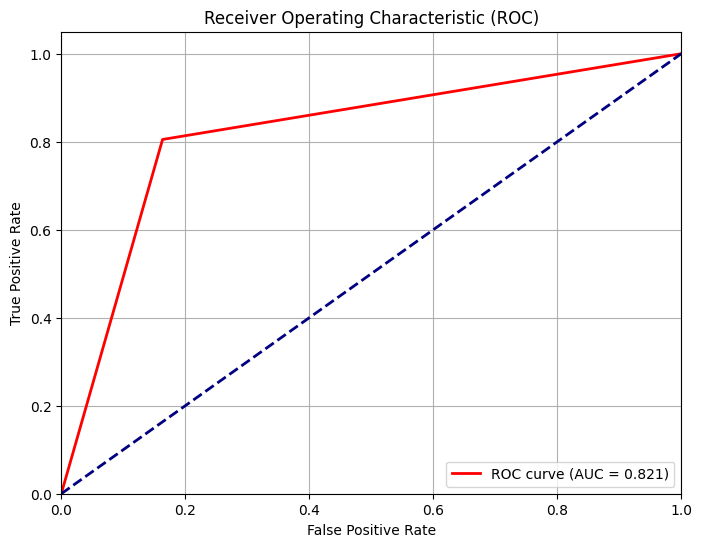

In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# segmentation

## dataset rle

In [ ]:
def rle_decode(mask_rle, shape):
    if pd.isnull(mask_rle) or mask_rle == '':
        # Pas de maladie -> masque vide
        return np.zeros(shape, dtype=np.uint8)

    s = mask_rle.strip().split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T  # reshape et transpose pour correspondre à l'image

## dataset image

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, img_dir, img_shape, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['ImageId']
        rle = row['EncodedPixels']

        # Lire l'image DICOM
        dicom_path = os.path.join(self.img_dir, f"{img_id}.dcm")
        ds = pydicom.dcmread(dicom_path)
        img = ds.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)

        # Créer le masque
        mask = rle_decode(rle, self.img_shape).astype(np.float32)

        # Convertir en images PIL pour Albumentations
        img = Image.fromarray((img*255).astype(np.uint8))
        mask = Image.fromarray((mask*255).astype(np.uint8))

        # Appliquer les transformations
        if self.transform:
            augmented = self.transform(image=np.array(img), mask=np.array(mask))
            img = augmented['image']
            mask = augmented['mask']

        return img, mask

## split train/test

In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['disease'],
    random_state=42
)

## transform

In [ ]:
# Transformations pour le set d'entraînement
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),   # images 1 canal
    ToTensorV2()
])

# Transformations pour le set de validation
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

## dataloader

In [ ]:
BATCH_SIZE = 256
img_shape_original = (1024, 1024)

train_dataset = SegmentationDataset(train_df, train_folder, img_shape_original, transform=train_transform)
val_dataset   = SegmentationDataset(val_df, train_folder, img_shape_original, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## definir le modele

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,   # DICOM grayscale
    classes=1        # sortie binaire
)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## boucle d'entrainement

In [ ]:
EPOCHS = 2

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # ----- Phase d'entraînement -----
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        masks = masks.unsqueeze(1).float() # Cast mask to float
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)

    # ----- Phase de validation -----
    model.eval()
    val_loss = 0.0
    dice_score = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float() # Cast mask to float
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            intersection = (preds * masks).sum()
            union = preds.sum() + masks.sum()
            dice_score += (2 * intersection / (union + 1e-7))

    val_loss /= len(val_loader.dataset)
    dice_score /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {dice_score:.4f}")

Epoch 1/2


  0%|          | 0/17 [01:32<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 78.12 MiB is free. Process 9009 has 14.66 GiB memory in use. Of the allocated memory 13.69 GiB is allocated by PyTorch, and 869.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# test

In [ ]:
# --- Paramètres ---
IMG_SIZE = 224
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset pour les images non annotées ---
class InferenceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.filenames = os.listdir(img_dir)  # récupérer tous les fichiers
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.img_dir, filename)

        # Lecture DICOM
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array.astype('float32')
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)
        img = Image.fromarray((img * 255).astype('uint8')).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, filename

# --- Transformations ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- Dataset & DataLoader ---
valid_ds = InferenceDataset(valid_folder, transform=transform)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# --- Boucle d'inférence ---
model.eval()
results = []

with torch.no_grad():
    for imgs, filenames in valid_loader:
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs))
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()

        for f, p in zip(filenames, preds):
            results.append({"ID": f, "disease": int(p)})

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("Results.csv", index=False)
df_results.head()

,ID,disease
0,1.2.276.0.7230010.3.1.4.8323329.1034.151787516...,0
1,1.2.276.0.7230010.3.1.4.8323329.1017.151787516...,1
2,1.2.276.0.7230010.3.1.4.8323329.1006.151787516...,0
3,1.2.276.0.7230010.3.1.4.8323329.1008.151787516...,0
4,1.2.276.0.7230010.3.1.4.8323329.1027.151787516...,0
